In [187]:
# Imported Libraries
#!pip install pandas-datareader
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from math import log, exp
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [188]:
# Obtaining Data Through Data Reader
Alphabet = data.DataReader('GOOGL', 'yahoo', datetime.datetime(2004, 1, 1), datetime.date.today())
Alphabet.reset_index(inplace=True) # RUN ONLY ONCE

In [189]:
Alphabet

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,52.082081,48.028027,50.050049,50.220219,44659096.0,50.220219
1,2004-08-20,54.594597,50.300301,50.555557,54.209209,22834343.0,54.209209
2,2004-08-23,56.796799,54.579578,55.430431,54.754753,18256126.0,54.754753
3,2004-08-24,55.855858,51.836838,55.675674,52.487488,15247337.0,52.487488
4,2004-08-25,54.054054,51.991993,52.532532,53.053055,9188602.0,53.053055
...,...,...,...,...,...,...,...
4167,2021-03-10,2061.399902,2019.329956,2061.399902,2036.189941,1353100.0,2036.189941
4168,2021-03-11,2111.270020,2056.449951,2058.219971,2100.540039,1384200.0,2100.540039
4169,2021-03-12,2077.610107,2032.420044,2076.409912,2050.000000,1690000.0,2050.000000
4170,2021-03-15,2054.989990,2027.790039,2044.979980,2054.439941,1308400.0,2054.439941


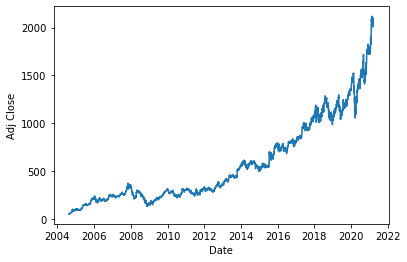

In [190]:
plt.plot(Alphabet['Date'], Alphabet['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

In [191]:
def MAPE(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))

In [192]:
# End of the Year ARIMA Model
end_year = Alphabet.groupby(Alphabet.Date.dt.year).last()['Adj Close']
testing_model = ARIMA(list(end_year[:-4].values), order = (1, 0, 2)).fit()
testing_forecasts = list(testing_model.forecast(steps = 3))
print('Forecasts (2018-2020):\t', [round(x,2) for x in testing_forecasts])
print('Actual (2018-2020):\t', [round(x,2) for x in list(end_year[-4:-1].values)])
print('MAPE:\t\t\t {}'.format(MAPE(list(end_year[-4:-1].values), testing_forecasts)))

# Forecasting End of Year Value for 2021
model1 = ARIMA(list(end_year.values), order = (1, 0, 2)).fit()
forecasts1 = list(model1.forecast(steps = 1))
forecasts1 = forecasts1[-1]
print('\nEnd of Year Forecast for 2021: ${}'.format(forecasts1))

Forecasts (2018-2020):	 [996.62, 1099.5, 1069.48]
Actual (2018-2020):	 [1044.96, 1339.39, 1752.64]
MAPE:			 0.20504933835897632

End of Year Forecast for 2021: $2253.559295579829


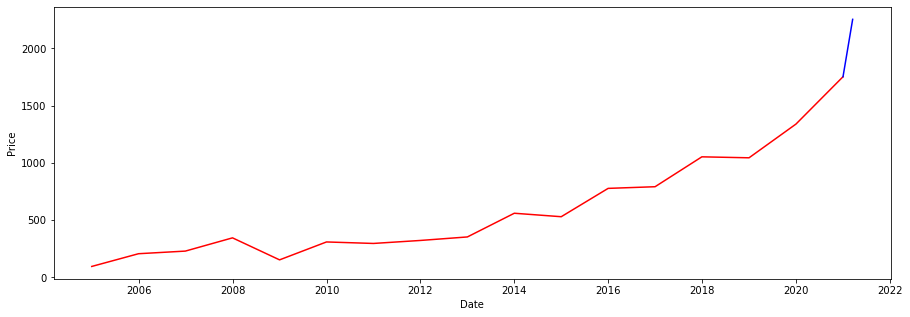

In [193]:
# Checking Yearly Forecast
to_graph = Alphabet.groupby(Alphabet.Date.dt.year).last()[['Date', 'Adj Close']]
to_graph.loc[2021,'Adj Close'] = forecasts1
plt.figure(figsize = (15,5))
plt.plot(to_graph['Date'][:-1], to_graph['Adj Close'][:-1], color = 'red')
plt.plot(to_graph['Date'][-2:], to_graph['Adj Close'][-2:], color = 'blue')
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [194]:
Alphabet['Month'] = Alphabet.Date.dt.month
end_month = pd.DataFrame(Alphabet[Alphabet.Date.dt.year == 2004].groupby('Month').last())
for year in sorted(set(Alphabet.Date.dt.year))[1:]:
    end_month = end_month.append(pd.DataFrame(Alphabet[Alphabet.Date.dt.year == year].groupby('Month').last()), sort=False)
end_month = end_month.reset_index(drop = True)
end_month = end_month[['Date','Adj Close']]

In [195]:
testing_model = ARIMA(list(end_month['Adj Close'].values[:-4]), order = (8, 2, 0)).fit()
testing_forecasts = list(testing_model.forecast(steps = 3))

print('Forecasts:\t', [round(x,2) for x in testing_forecasts])
print('Actual:\t\t', [round(x,2) for x in end_month['Adj Close'].values[-4:-1]])

MSE_error = mean_absolute_error(end_month['Adj Close'].values[-4:-1], testing_forecasts)
print('MAPE:\t\t {}'.format(MAPE(list(end_month['Adj Close'].values[-4:-1]), testing_forecasts)))

# Forecasting End of Month Value for Dec 2021
forecasts2 = list(testing_model.forecast(steps = 13))
forecasts2 = forecasts2
print('\nEnd of Month Forecast for Dec 2021: ${}'.format(forecasts2[-1]))

Forecasts:	 [1706.81, 1765.63, 1902.66]
Actual:		 [1752.64, 1827.36, 2021.91]
MAPE:		 0.03963611453892759

End of Month Forecast for Dec 2021: $2342.8741842478853


In [196]:
forecast_dates = [i.date() for i in list(pd.date_range(start = "2020-12-30", 
                                                       end = "2021-12-31"))[1:] 
                  if i.weekday() in [0, 1, 2, 3, 4]]

In [197]:
i = pd.DataFrame(forecast_dates)
i['Month'] = [x.month for x in list(i[0])]
i = i.groupby('Month').last().reset_index(drop = True)
i['Adj Close'] = forecasts2[1:]

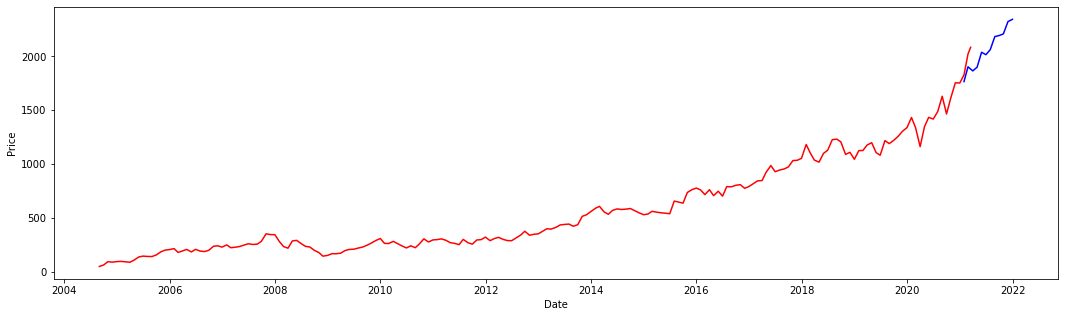

In [198]:
# Checking Monthly Forecast 
plt.figure(figsize=(18,5))
plt.plot(end_month["Date"], end_month["Adj Close"], color = 'red')
plt.plot(i[0], i['Adj Close'], color = 'blue') # Monthly ARIMA
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [199]:
US = data.DataReader('DX-Y.NYB', 'yahoo', datetime.datetime(2006, 9, 29), datetime.date.today())
US.reset_index(inplace=True)
Quarters = []
for m in US.Date:
    m = m.month
    if m in [1, 2, 3]:
        Quarters.append('Quarter 1')
    elif m in [4, 5, 6]:
        Quarters.append('Quarter 2')
    elif m in [7, 8, 9]:
        Quarters.append('Quarter 3')
    elif m in [10, 11, 12]:
        Quarters.append('Quarter 4')
US['Quarter'] = Quarters
US['Year'] = US.Date.dt.year

In [200]:
Quarters = []
for m in Alphabet.Month:
    if m in [1, 2, 3]:
        Quarters.append('Quarter 1')
    elif m in [4, 5, 6]:
        Quarters.append('Quarter 2')
    elif m in [7, 8, 9]:
        Quarters.append('Quarter 3')
    elif m in [10, 11, 12]:
        Quarters.append('Quarter 4')
Alphabet['Quarter'] = Quarters
Alphabet['Year'] = Alphabet.Date.dt.year

In [201]:
# Quarterly ARIMA
q_order = (25, 0, 10)
end_year = Alphabet.groupby(['Year', 'Quarter']).last()['Adj Close']
testing_model = ARIMA(list(end_year[:-4].values), order = q_order).fit()
testing_forecasts = list(testing_model.forecast(steps = 3))
print('Forecasts (2018-2020):\t', [round(x,2) for x in testing_forecasts])
print('Actual (2018-2020):\t', [round(x,2) for x in list(end_year[-4:-1].values)])
print('MAPE:\t\t\t {}'.format(MAPE(list(end_year[-4:-1].values), testing_forecasts)))

# Forecasting End of Year Value for 2021
model3 = ARIMA(list(end_year.values), order = q_order).fit()
forecasts3 = list(model3.forecast(steps = 3))
forecasts3 = forecasts3[-1]
print('\nEnd of Year Forecast for 2021: ${}'.format(forecasts3))

Forecasts (2018-2020):	 [1312.4, 1280.27, 1305.43]
Actual (2018-2020):	 [1418.05, 1465.6, 1752.64]
MAPE:			 0.15204131569181456

End of Year Forecast for 2021: $2191.6628553604933


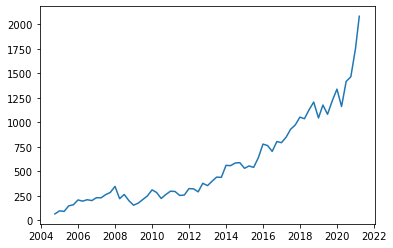

In [202]:
plt.plot(Alphabet.groupby(['Year', 'Quarter']).last()['Date'], end_year.values)

In [203]:
Alphabet['Week'] = Alphabet.Date.dt.week
week_data = Alphabet.groupby(['Year', 'Week']).last()
week_data = week_data[['Date','Adj Close', 'Month']]

testing_model = ARIMA(list(week_data['Adj Close'][:-20].values), order = (14,2,0)).fit()
testing_forecasts = list(testing_model.forecast(steps = 19))
actual_values = list(week_data['Adj Close'][-20:-1].values)
weekly_dict = {'Actual': actual_values, 'Forecast': testing_forecasts}
weekly_dict = pd.DataFrame(weekly_dict, columns = weekly_dict.keys())
print('MAPE:\t\t\t {}'.format(MAPE(actual_values, testing_forecasts)))
print(weekly_dict)

forecasts4 = list(testing_model.forecast(steps = 62))
forecasts4 = forecasts4[-1]
print('Weekly Arima Forecast for Dec 31st, 2021: ${}'.format(forecasts4))

MAPE:			 0.072101207118672
         Actual     Forecast
0   1759.729980  1620.099280
1   1772.260010  1641.953388
2   1736.380005  1664.628299
3   1787.020020  1689.834716
4   1823.760010  1698.872802
5   1774.800049  1690.668366
6   1726.219971  1680.116520
7   1734.160034  1674.891595
8   1752.640015  1683.538053
9   1797.829956  1706.983342
10  1727.619995  1732.500546
11  1892.560059  1754.837647
12  1827.359985  1771.174009
13  2088.830078  1779.585687
14  2095.030029  1791.137165
15  2088.810059  1807.947139
16  2021.910034  1824.120347
17  2097.070068  1837.750203
18  2050.000000  1846.573093
Weekly Arima Forecast for Dec 31st, 2021: $2373.249452187249


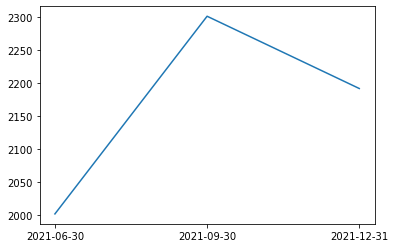

In [204]:
plt.plot(['2021-06-30', '2021-09-30', '2021-12-31'], list(model3.forecast(steps = 3)))

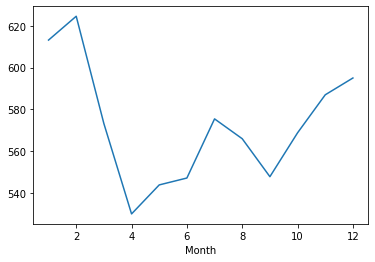

In [205]:
Alphabet.groupby(['Month']).mean()['Adj Close'].plot()

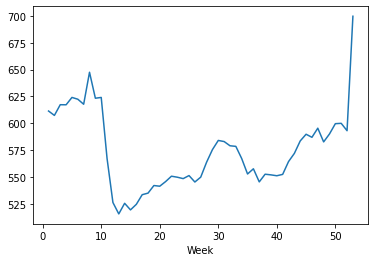

In [206]:
Alphabet.groupby(['Week']).mean()['Adj Close'].plot()

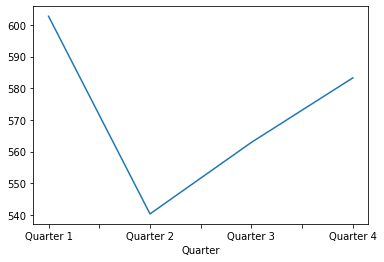

In [207]:
Alphabet.groupby(['Quarter']).mean()['Adj Close'].plot()

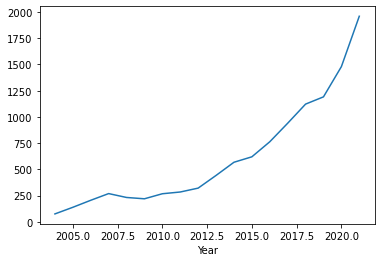

In [208]:
Alphabet.groupby(['Year']).mean()['Adj Close'].plot()

In [209]:
import os
os.chdir('C:/Users/jaina/Downloads')
quarter_data = pd.read_csv('quarterData.csv')
quarter_data2 = pd.read_csv('quarterData2.csv')
quarter_data["Date"] = pd.to_datetime(quarter_data["Date"])
quarter_prev = quarter_data[:57]
quarter_2021 = quarter_data[57:]
quarter_prev['USD'] = US.groupby(['Year', 'Quarter']).last()['Adj Close'].values[1:-1]
quarter_current = quarter_data[:58]

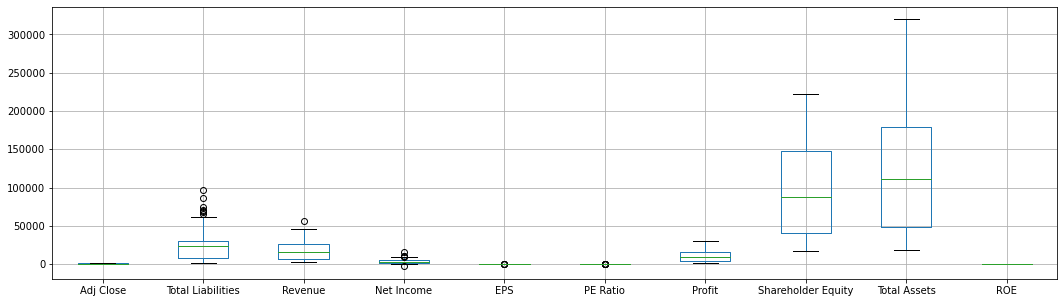

In [210]:
plt.figure(figsize=(18,5))
boxplot = quarter_prev.boxplot(column = ['Adj Close', 'Total Liabilities', 'Revenue',
       'Net Income', 'EPS', 'PE Ratio', 'Profit', 'Shareholder Equity',
       'Total Assets', 'ROE'])

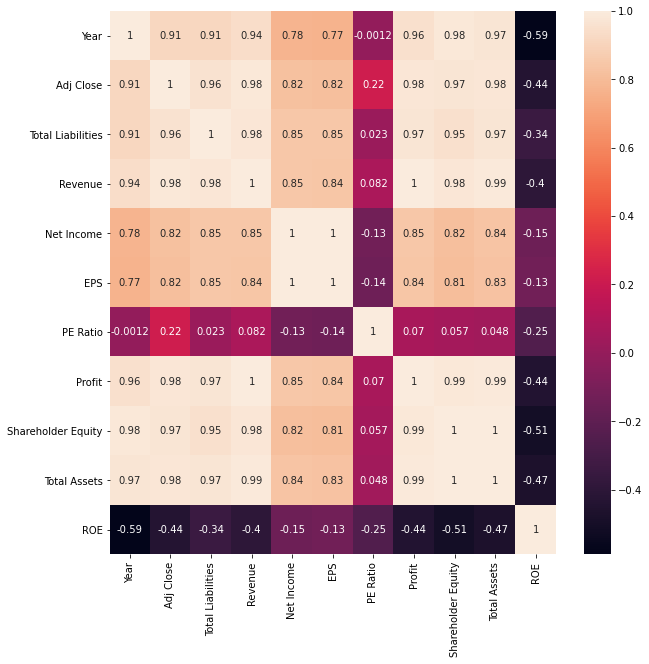

In [211]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(quarter_data.corr(), annot=True)

In [212]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [213]:
X = pd.get_dummies(data=quarter_prev, drop_first=True)
X['SharePrice'] = X['EPS'] * X['PE Ratio']
X['EquityReturn'] = X['ROE'] * X['Shareholder Equity']
X = X[['Net Income', 'Profit', 'SharePrice', 'EquityReturn']]
Y = quarter_prev['Adj Close']

training_x, testing_x, training_y, testing_y = train_test_split(X, Y, test_size = 0.2, random_state=101)
model = LinearRegression().fit(training_x, training_y)

results = sm.OLS(training_y, training_x).fit()
results.summary()
    
model = LinearRegression().fit(training_x, training_y) 
pred_regression = [int(x) for x in list(model.predict(training_x))]
pred_y = [int(x) for x in list(model.predict(testing_x[:-1]))]
    
print('Testing Set Prediction Values:\t', pred_y)
print('Testing Set Actual Values:\t', [int(x) for x in testing_y[:-1]])
    
print('R^2:', model.score(training_x, training_y))
print('MAPE: {}'.format(MAPE(training_y, pred_regression)))

print('Linear Regression: Intercept:', model.intercept_)
print('Linear Regression: Slope(s):', model.coef_)

results = sm.OLS(training_y,training_x).fit()
results.summary()

Testing Set Prediction Values:	 [347, 301, 904, 440, 193, 389, 550, 1084, 609, 284, 566]
Testing Set Actual Values:	 [323, 297, 929, 440, 229, 354, 530, 1044, 1053, 253, 584]
R^2: 0.9891604431812603
MAPE: 0.07238965885894665
Linear Regression: Intercept: 6.203150256627737
Linear Regression: Slope(s): [-0.09911103  0.02820574  1.98839878  0.02320246]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Adj Close   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              3072.
Date:                Wed, 17 Mar 2021   Prob (F-statistic):                    3.39e-50
Time:                        02:58:50   Log-Likelihood:                         -232.72
No. Observations:                  45   AIC:                                      473.4
Df Residuals:                      41   BIC:                                      480.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Net Income      -0.1033      0.016     -6.423      0.000      -0.136      -0.071
Profit           0.0271      0.007      4.012      0.000       0.013       0.041
SharePrice       2.0564      0.277      7.417      0.000       1.496       2.616
EquityReturn     0.0246      0.005      4.660      0.000       0.014       0.035
==============================================================================
Omnibus:                        0.253   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.078
Skew:                          -0.101   Prob(JB):                        0.962
Kurtosis:                       2.973   Cond. No.                         971.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [214]:
calc_vif(X.iloc[:,:-1])

,variables,VIF
0,Net Income,39.338445
1,Profit,10.112033
2,SharePrice,21.750734


In [215]:
prediction_table = quarter_2021[['Date','Adj Close', 'Net Income', 'Profit', 'EPS', 'PE Ratio', 'Shareholder Equity', 'ROE']]
prediction_table

,Date,Adj Close,Net Income,Profit,EPS,PE Ratio,Shareholder Equity,ROE
57,2021-03-12,2050.0,NaN,NaN,NaN,34.92,NaN,NaN
58,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
eps_arima = ARIMA(quarter_prev['EPS'], order = auto_arima(quarter_prev['EPS'], suppress_warnings=True).order).fit()
eps_forecast = list(eps_arima.forecast(steps = 4))

pe_arima = ARIMA(quarter_current['PE Ratio'], order = auto_arima(quarter_current['PE Ratio'], suppress_warnings=True).order).fit()
pe_forecast = list(pe_arima.forecast(steps = 3))

income_arima = ARIMA(quarter_prev['Net Income'], order = auto_arima(quarter_prev['Net Income'], suppress_warnings=True).order).fit()
income_forecast = list(income_arima.forecast(steps = 4))

profit_arima = ARIMA(quarter_prev['Profit'], order = auto_arima(quarter_prev['Profit'], suppress_warnings=True).order).fit()
profit_forecast = list(profit_arima.forecast(steps = 4))

equity_arima = ARIMA(quarter_prev['Shareholder Equity'], order = auto_arima(quarter_prev['Shareholder Equity'], suppress_warnings=True).order).fit()
equity_forecast = list(equity_arima.forecast(steps = 4))

ROE_forecast = [0.220125498176348,0.241914580100029,0.244783190504886,0.246287979450537] # From Alteryx

In [217]:
prediction_table['Net Income'] = income_forecast
prediction_table['Shareholder Equity'] = equity_forecast
prediction_table['ROE'] = ROE_forecast
prediction_table['EPS'] = eps_forecast
prediction_table['Profit'] = profit_forecast
prediction_table['PE Ratio'] = [34.92] + list(pe_forecast)
prediction_table['SharePrice'] = prediction_table['EPS'] * prediction_table['PE Ratio']
prediction_table['EquityReturn'] = prediction_table['ROE'] * prediction_table['Shareholder Equity']
predictions = list(model.predict(prediction_table[['Net Income', 'Profit', 'SharePrice', 'EquityReturn']]))
prediction_table['Prediction'] = predictions
print('Linear Regression Model Price Prediction for 31st Dec, 2021: ${}'.format(predictions[-1]))

Linear Regression Model Price Prediction for 31st Dec, 2021: $2290.4157641137135


In [218]:
quarter_data2 = pd.read_csv('quarterData2.csv')
quarter_data2["Date"] = pd.to_datetime(quarter_data["Date"])
quarter_data2 = quarter_data2[quarter_data2.Date > '2012-06-29']
quarter_prev2 = quarter_data2[:57]
quarter_2021_2 = quarter_data2[57:]
quarter_current2 = quarter_data2[:58]

In [219]:
Alphabet2 = Alphabet[Alphabet.Date >= '2012-09-27'].reset_index(drop = True)

Alphabet2['Apple_Volume'] = data.DataReader('AAPL', 'yahoo', datetime.datetime(2012, 9, 27), datetime.date.today())['Volume'].values
Alphabet2['Apple_Adj_Close'] = data.DataReader('AAPL', 'yahoo', datetime.datetime(2012, 9, 27), datetime.date.today())['Adj Close'].values

Alphabet2['Microsoft_Volume'] = data.DataReader('MSFT', 'yahoo', datetime.datetime(2012, 9, 27), datetime.date.today())['Volume'].values
Alphabet2['Microsoft_Adj_Close'] = data.DataReader('MSFT', 'yahoo', datetime.datetime(2012, 9, 27), datetime.date.today())['Adj Close'].values

Alphabet2['Facebook_Volume'] = data.DataReader('FB', 'yahoo', datetime.datetime(2012, 9, 27), datetime.date.today())['Volume'].values
Alphabet2['Facebook_Adj_Close'] = data.DataReader('FB', 'yahoo', datetime.datetime(2012, 9, 27), datetime.date.today())['Adj Close'].values

Alphabet2 = Alphabet2.groupby(['Year','Quarter']).last()
Alphabet2 = Alphabet2[Alphabet2.Date.dt.year <= 2020]
Alphabet2['GDP'] = list(quarter_prev2['GDP'].values)[:-4]
Alphabet2['Unemployment'] = list((quarter_prev2['Unemployment Rate (%)']).values)[:-4]

for col in ['Total Liabilities', 'Revenue',
       'Net Income', 'EPS', 'PE Ratio', 'Profit', 'Shareholder Equity',
       'Total Assets', 'ROE', 'USD']:
    Alphabet2[col] = quarter_prev[quarter_prev.Date >= '2012-09-28'][col].values

In [220]:
X = pd.get_dummies(data = Alphabet2, drop_first=True)
X['SharePrice'] = X['EPS'] * X['PE Ratio']
X['EquityReturn'] = X['ROE'] * X['Shareholder Equity']
X['Unemployment'] = (X['Unemployment']) ** (-1)
X['Volume'] = X['Volume'].apply(log)
X['CompVolume'] = X['Apple_Volume'].apply(log) * X['Microsoft_Volume'].apply(log) * X['Facebook_Volume'].apply(log)
X = X[['Net Income', 'Profit', 'SharePrice', 'EquityReturn', 'GDP', 'CompVolume']]
Y = Alphabet2['Adj Close']

training_x, testing_x, training_y, testing_y = train_test_split(X, Y, test_size = 0.2, random_state=101)

results = sm.OLS(training_y, training_x).fit()
results.summary()
    
model = LinearRegression().fit(training_x, training_y) 
pred_regression = [int(x) for x in list(model.predict(training_x))]
pred_y = [int(x) for x in list(model.predict(testing_x[:-1]))]
    
#print('Testing Set Prediction Values:\t', pred_y)
#print('Testing Set Actual Values:\t', [int(x) for x in testing_y[:-1]])
    
print('R^2:', model.score(training_x, training_y))
print('MAPE: {}'.format(MAPE(training_y, pred_regression)))

print('Linear Regression: Intercept:', model.intercept_)
print('Linear Regression: Slope(s):', model.coef_)

results = sm.OLS(training_y,training_x).fit()
results.summary()

R^2: 0.986936428189416
MAPE: 0.04436355926419937
Linear Regression: Intercept: 823.9538108565605
Linear Regression: Slope(s): [-0.12283452  0.07145402  1.77212729  0.01994431 -0.06998555  0.02111257]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Adj Close   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              1407.
Date:                Wed, 17 Mar 2021   Prob (F-statistic):                    3.14e-26
Time:                        02:59:01   Log-Likelihood:                         -140.88
No. Observations:                  27   AIC:                                      293.8
Df Residuals:                      21   BIC:                                      301.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Net Income      -0.1185      0.018     -6.405      0.000      -0.157      -0.080
Profit           0.0656      0.007      9.711      0.000       0.052       0.080
SharePrice       1.6695      0.263      6.354      0.000       1.123       2.216
EquityReturn     0.0197      0.005      4.153      0.000       0.010       0.030
GDP             -0.0359      0.011     -3.387      0.003      -0.058      -0.014
CompVolume       0.0700      0.024      2.875      0.009       0.019       0.121
==============================================================================
Omnibus:                        5.660   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                3.778
Skew:                          -0.735   Prob(JB):                        0.151
Kurtosis:                       4.094   Cond. No.                         890.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
apple_arima = ARIMA(Alphabet2['Apple_Volume'].values, order = (2,1,2)).fit()
apple_forecast = list(apple_arima.forecast(steps = 4))

microsoft_arima = ARIMA(Alphabet2['Microsoft_Volume'].values, order = (1,2,1)).fit()
microsoft_forecast = list(microsoft_arima.forecast(steps = 4))

facebook_arima = ARIMA(Alphabet2['Facebook_Volume'].values, order = (1,1,0)).fit()
facebook_forecast = list(facebook_arima.forecast(steps = 4))

gdp_arima = ARIMA(Alphabet2['GDP'].values, order = (2,1,2)).fit()
gdp_forecast = list(gdp_arima.forecast(steps = 4))

prediction_table['Apple_Volume'] = apple_forecast
prediction_table['Microsoft_Volume'] = microsoft_forecast
prediction_table['Facebook_Volume'] = facebook_forecast
prediction_table['GDP'] = gdp_forecast
prediction_table['CompVolume'] = prediction_table['Apple_Volume'].apply(log) * prediction_table['Microsoft_Volume'].apply(log) * prediction_table['Facebook_Volume'].apply(log)

predictions2 = list(model.predict(prediction_table[['Net Income', 'Profit', 'SharePrice', 'EquityReturn', 'GDP', 'CompVolume']]))
prediction_table['Prediction2'] = predictions2
print('Linear Regression Model Price Prediction for 31st Dec, 2021: ${}'.format(predictions2[-1]))

Linear Regression Model Price Prediction for 31st Dec, 2021: $2572.2026546180496


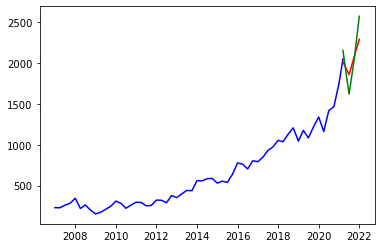

In [222]:
plt.plot(quarter_data['Date'], quarter_data['Adj Close'], color = 'blue')
plt.plot(prediction_table['Date'], prediction_table['Prediction'], color = 'red')
plt.plot(prediction_table['Date'], prediction_table['Prediction2'], color = 'green')
plt.show()

In [223]:
Alphabet['Week'] = Alphabet.Date.dt.week
week_data = Alphabet.groupby(['Year', 'Week']).last()
week_data = week_data[['Date','Adj Close', 'Month']]

testing_model = ARIMA(list(week_data['Adj Close'][:-20].values), order = (14,2,0)).fit()
testing_forecasts = list(testing_model.forecast(steps = 19))
actual_values = list(week_data['Adj Close'][-20:-1].values)
weekly_dict = {'Actual': actual_values, 'Forecast': testing_forecasts}
weekly_dict = pd.DataFrame(weekly_dict, columns = weekly_dict.keys())
print('MAPE:\t\t\t {}'.format(MAPE(actual_values, testing_forecasts)))
print(weekly_dict)

forecasts4 = list(testing_model.forecast(steps = 62))
forecasts4 = forecasts4[-1]
print('Weekly Arima Forecast for Dec 31st, 2021: ${}'.format(forecasts4))

MAPE:			 0.072101207118672
         Actual     Forecast
0   1759.729980  1620.099280
1   1772.260010  1641.953388
2   1736.380005  1664.628299
3   1787.020020  1689.834716
4   1823.760010  1698.872802
5   1774.800049  1690.668366
6   1726.219971  1680.116520
7   1734.160034  1674.891595
8   1752.640015  1683.538053
9   1797.829956  1706.983342
10  1727.619995  1732.500546
11  1892.560059  1754.837647
12  1827.359985  1771.174009
13  2088.830078  1779.585687
14  2095.030029  1791.137165
15  2088.810059  1807.947139
16  2021.910034  1824.120347
17  2097.070068  1837.750203
18  2050.000000  1846.573093
Weekly Arima Forecast for Dec 31st, 2021: $2373.249452187249


In [224]:
# Support Vector Regression Model 
SVM_data = Alphabet[['Date', 'Adj Close']]
SVM_data['Prediction'] = SVM_data[['Adj Close']].shift(-207) #207 Business Days till Dec 31st, 2021
X = np.array(SVM_data.drop(['Date','Prediction'],1))[:-207]
Y = np.array(SVM_data['Prediction'])[:-207]
training_x, testing_x, training_y, testing_y = train_test_split(X, Y, test_size = 0.2)
SVM_Model = SVR(kernel = 'rbf', C = 1e3, gamma = 0.00000001).fit(training_x, training_y)
print('MAPE: {}'.format(MAPE(training_y, SVM_Model.predict(training_x))))
predictions3 = list(SVM_Model.predict(np.array(SVM_data.drop(['Date','Prediction'],1))[-207:]))
SVM_data['Prediction'][-207:] = predictions3
print('SVM Model Price Prediction for 31st Dec, 2021: ${}'.format(predictions3[-1]))

MAPE: 0.16744695276196886
SVM Model Price Prediction for 31st Dec, 2021: $2355.185496403477


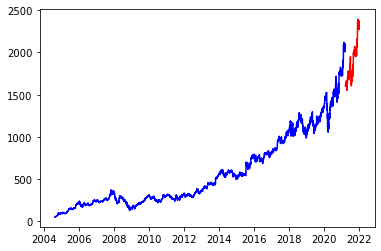

In [226]:
forecast_dates = [i.date() for i in list(pd.date_range(start = '2021-03-16', 
                                                       end = "2021-12-31"))[1:] if i.weekday() in [0, 1, 2, 3, 4]][1:]
plt.plot(SVM_data['Date'], SVM_data['Adj Close'], color = 'blue')
plt.plot(forecast_dates, predictions3, color = 'red')
plt.show()

In [227]:
print('ARIMA Model (Weekly) Prediction for 31st Dec, 2021:\t\t${}'.format(forecasts4))
print('ARIMA Model (Monthly) Prediction for 31st Dec, 2021:\t\t${}'.format(forecasts2[-1]))
print('ARIMA Model (Quarterly) Prediction for 31st Dec, 2021:\t\t${}'.format(forecasts3))
print('ARIMA Model (Annual) Prediction for 31st Dec, 2021:\t\t${}'.format(forecasts1))
print('Linear Regression Model 1 Price Prediction for 31st Dec, 2021:\t${}'.format(predictions[-1]))
print('Linear Regression Model 2 Price Prediction for 31st Dec, 2021:\t${}'.format(predictions2[-1]))
print('SVM Model Price Prediction for 31st Dec, 2021:\t\t\t${}'.format(predictions3[-1]))

ARIMA Model (Weekly) Prediction for 31st Dec, 2021:		$2373.249452187249
ARIMA Model (Monthly) Prediction for 31st Dec, 2021:		$2342.8741842478853
ARIMA Model (Quarterly) Prediction for 31st Dec, 2021:		$2191.6628553604933
ARIMA Model (Annual) Prediction for 31st Dec, 2021:		$2253.559295579829
Linear Regression Model 1 Price Prediction for 31st Dec, 2021:	$2290.4157641137135
Linear Regression Model 2 Price Prediction for 31st Dec, 2021:	$2572.2026546180496
SVM Model Price Prediction for 31st Dec, 2021:			$2355.185496403477
